In [31]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
import tarfile
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Load the CIFAR10 Dataset

In [32]:
from torchvision.datasets.utils import download_url

dataset = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz" 
download_url(dataset, '.')

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
data_folder = './data/cifar10' 
print(os.listdir(data_folder))
entries = os.listdir(data_folder + "/train") 
print(entries)

Using downloaded and verified file: ./cifar10.tgz
['test', 'train']
['ship', 'dog', 'frog', 'deer', 'horse', 'automobile', 'truck', 'bird', 'airplane', 'cat']


Data Transformation

In [33]:
norm = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
training_transform = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*norm,inplace=True)])
validating_transform = tt.Compose([tt.ToTensor(), tt.Normalize(*norm)]) 

PyTorch datasets

In [35]:
training_data = ImageFolder(data_folder+'/train', training_transform)
validating_data = ImageFolder(data_folder+'/test', validating_transform) 

In [36]:
no_of_samples = 400 

PyTorch data loaders

In [37]:
training_load = DataLoader(training_data, no_of_samples, shuffle=True, num_workers=3, pin_memory=True)
validating_load = DataLoader(validating_data, no_of_samples*2, num_workers=3, pin_memory=True) 

In [38]:
def original_data(imgs, list_mean, list_stds): 
    list_mean = torch.tensor(list_mean).reshape(1, 3, 1, 1)
    list_stds = torch.tensor(list_stds).reshape(1, 3, 1, 1)
    return imgs * list_stds + list_mean

def batch_images(data_load):
    for imgs, tlabels in data_load: 
        fig, batch_plots = plt.subplots(figsize=(12, 12)) 
        batch_plots.set_xticks([]); batch_plots.set_yticks([])
        denormalize_images = original_data(imgs, *norm) 
        batch_plots.imshow(make_grid(denormalize_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

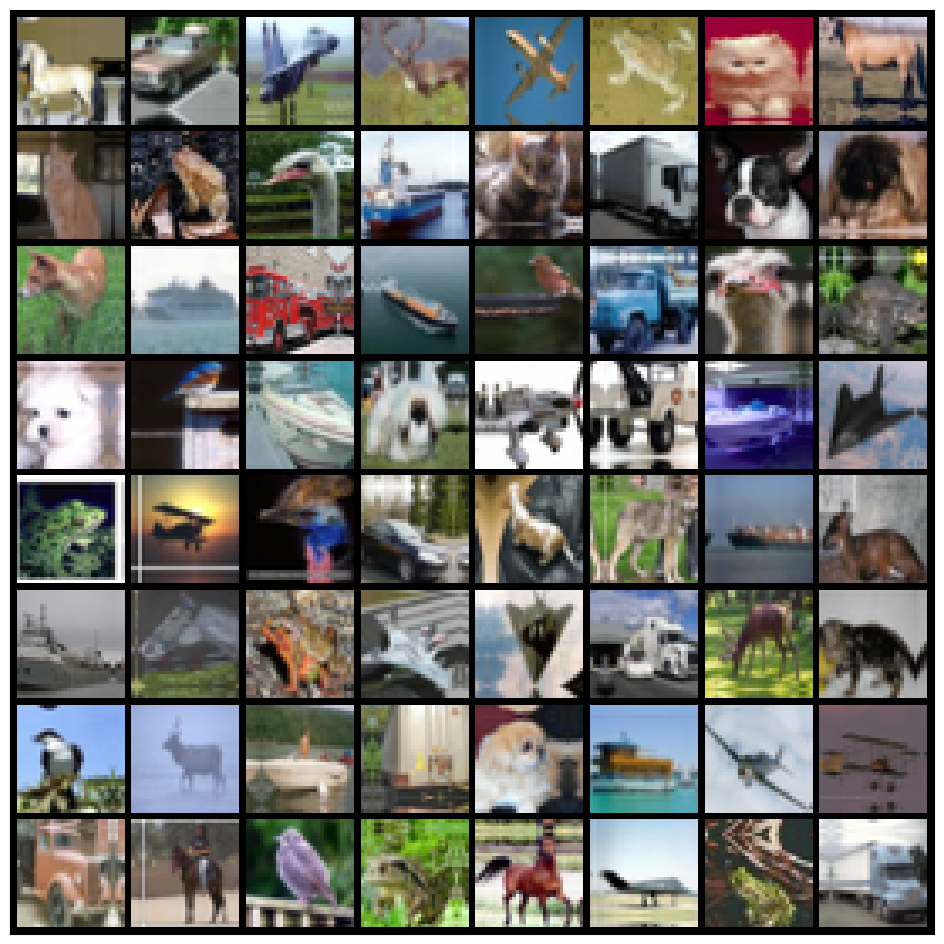

In [39]:
batch_images(training_load)

Using a GPU

In [40]:
def get_def_dev(): 
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def specific_tool(info, tool): 
    if isinstance(info, (list,tuple)):
        return [specific_tool(x, tool) for x in info]
    return info.to(tool, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, tool):
        self.dl = dl
        self.tool = tool
        
    def __iter__(self):
        for b in self.dl: 
            yield specific_tool(b, self.tool)

    def __len__(self):
        return len(self.dl)

In [41]:
tool = get_def_dev()
tool

device(type='cuda')

In [42]:
training_load = DeviceDataLoader(training_load, tool)
validating_load = DeviceDataLoader(validating_load, tool)

Introducing Residual blocks and Batch Normalization

In [43]:
class SimpleResidualBlock(nn.Module): 
    def __init__(self):
        super().__init__()
        self.con1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.re1 = nn.ReLU()
        self.con2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU()
        
    def forward(self, x):
        output = self.con1(x)
        output = self.re1(output)
        output = self.con2(output)
        return self.re2(output) + x 

In [44]:
s_resnet = specific_tool(SimpleResidualBlock(), tool)

for imgs, tlb in training_load: 
    output = s_resnet(imgs)
    print(output.shape)
    break
    
del s_resnet, imgs, tlb
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [45]:
def t_acc(ans, tlb):
    _, preds = torch.max(ans, dim=1)
    return torch.tensor(torch.sum(preds == tlb).item() / len(preds))

class ImageClassificationBase(nn.Module): 
    def training_step(self, b_batch):
        imgs, tlb = b_batch 
        output = self(imgs)              
        loss = F.cross_entropy(output, tlb) 
        return loss
    
    def est_step(self, b_batch): 
        imgs, tlb = b_batch 
        output = self(imgs)                   
        loss = F.cross_entropy(output, tlb)  
        acc = t_acc(output, tlb)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def est_epoch(self, ans): 
        batch_losses = [x['val_loss'] for x in ans]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in ans]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def est_epoch_end(self, epoch, result): 
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [46]:
def c_block(in_channels, out_channels, pool=False): 
    c_layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: c_layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*c_layers)

class ResNet9(ImageClassificationBase): 
    def __init__(self, in_channels, num_classes): 
        super().__init__()
        
        self.con1 = c_block(in_channels, 64)
        self.con2 = c_block(64, 128, pool=True)
        self.r1 = nn.Sequential(c_block(128, 128), c_block(128, 128))
        
        self.con3 = c_block(128, 256, pool=True)
        self.con4 = c_block(256, 512, pool=True)
        self.r2 = nn.Sequential(c_block(512, 512), c_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        output = self.con1(xb)
        output = self.con2(output)
        output = self.r1(output) + output
        output = self.con3(output)
        output = self.con4(output)
        output = self.r2(output) + output
        output = self.classifier(output)
        return output

In [47]:
model = specific_tool(ResNet9(3, 10), tool)
model

ResNet9(
  (con1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (con2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (r1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)


Train the model

In [48]:
def estimate(super_model, val_loader): 
    super_model.eval()
    ans = [super_model.est_step(b_batch) for b_batch in val_loader]
    return super_model.est_epoch(ans)

def get_lr(enh_opt):
    for param_group in enh_opt.param_groups:
        return param_group['lr']

def cycle_one(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    enh_opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(enh_opt, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for b_batch in train_loader:
            loss = model.training_step(b_batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            enh_opt.step()
            enh_opt.zero_grad()
            lrs.append(get_lr(enh_opt))
            sched.step()
        
        result = estimate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.est_epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
history = [estimate(model, validating_load)]
history

[{'val_loss': 2.306065797805786, 'val_acc': 0.09942308813333511}]

In [50]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [51]:
%%time
history += cycle_one(epochs, max_lr, model, training_load, validating_load, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.5429, val_loss: 1.4876, val_acc: 0.5094
Epoch [1], last_lr: 0.00935, train_loss: 1.1313, val_loss: 1.5851, val_acc: 0.5303
Epoch [2], last_lr: 0.00972, train_loss: 0.8674, val_loss: 1.0735, val_acc: 0.6548
Epoch [3], last_lr: 0.00812, train_loss: 0.6338, val_loss: 0.6937, val_acc: 0.7739
Epoch [4], last_lr: 0.00556, train_loss: 0.5207, val_loss: 0.5010, val_acc: 0.8284
Epoch [5], last_lr: 0.00283, train_loss: 0.4126, val_loss: 0.4163, val_acc: 0.8566
Epoch [6], last_lr: 0.00077, train_loss: 0.3017, val_loss: 0.3208, val_acc: 0.8935
Epoch [7], last_lr: 0.00000, train_loss: 0.2270, val_loss: 0.2914, val_acc: 0.9019
CPU times: user 20.9 s, sys: 4.26 s, total: 25.2 s
Wall time: 5min 9s


In [52]:
def acc_plt(history): 
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

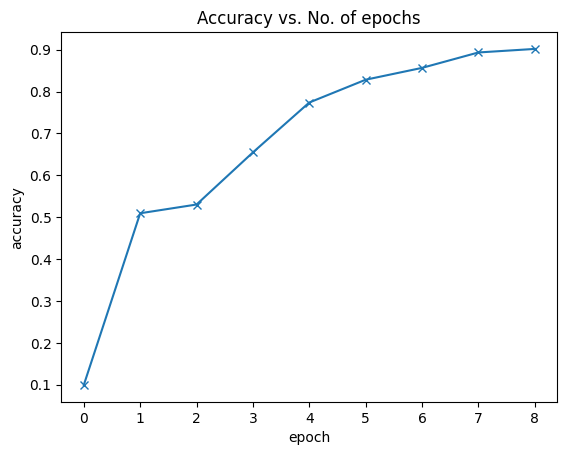

In [53]:
acc_plt(history)

In [54]:
def loss_plt(history): 
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

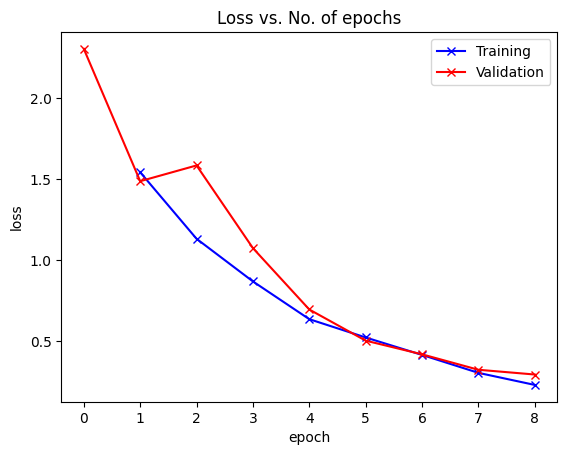

In [55]:
loss_plt(history)

In [56]:
def lrate_plt(history): 
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

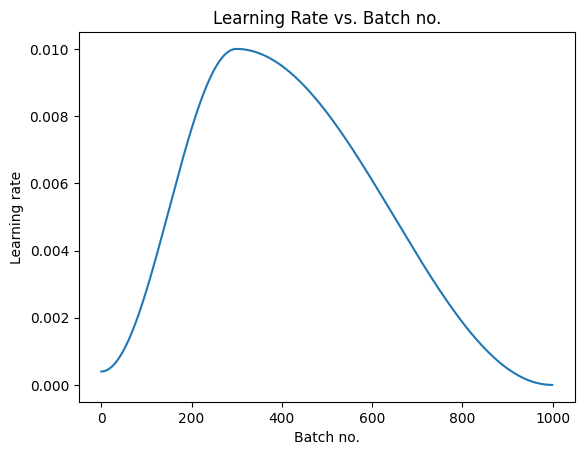

In [57]:
lrate_plt(history)

Testing with Individual Images

In [58]:
def img_pred(img, model): 
    xb = specific_tool(img.unsqueeze(0), tool)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return training_data.classes[preds[0].item()]

Label: airplane , Predicted: airplane


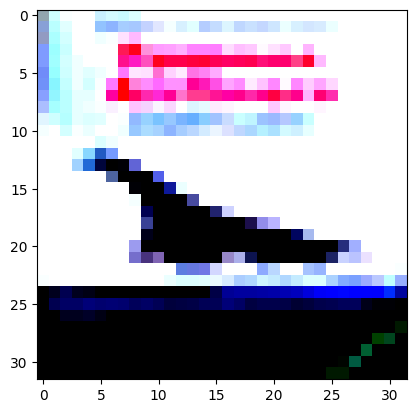

In [59]:
img, label = validating_data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', training_data.classes[label], ', Predicted:', img_pred(img, model))

Label: automobile , Predicted: truck


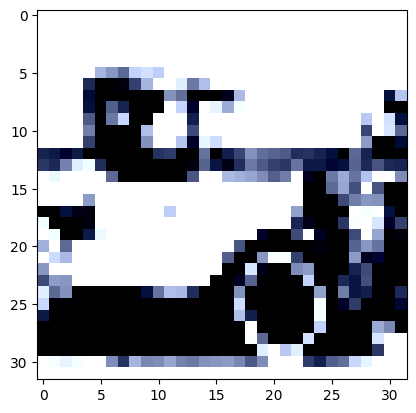

In [60]:
img, label = validating_data[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', validating_data.classes[label], ', Predicted:', img_pred(img, model))

Label: frog , Predicted: frog


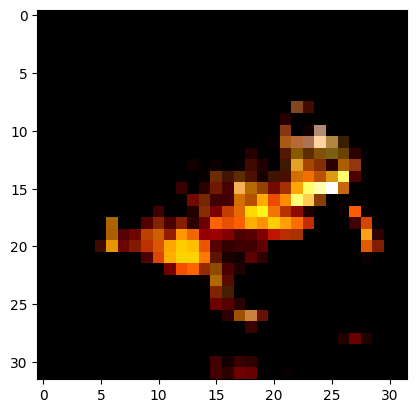

In [61]:
img, label = validating_data[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_data.classes[label], ', Predicted:', img_pred(img, model))